# Optimized Healthcare Simulation with Q-Learning
This notebook simulates a constrained healthcare system with patient flow across disease pathways, clinical interventions, and system-level optimization using Q-learning.

## Imports

In [2]:
# Step 1: Imports and Initial Setup
import numpy as np
import pandas as pd
import random

# Data manipulation and analysis
import itertools
from collections import defaultdict
import networkx as nx
import heapq

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go #Sankey diagram

# Set random seed for reproducibility if required
#np.random.seed(0)
#random.seed(0)

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Step 1 Define Classes

## Patient Class
- __ init __
- progress disease
- clinical_dec
- apply_action
- score_outcome

In [3]:
# Step 2: Define Patient Class with Time-Dependent Variables
class Patient:
    """
    Represents a patient in the healthcare simulation.

    Attributes:
        pid (int): Unique identifier for the patient.
        age (int): Age of the patient.
        sex (str): Gender of the patient ('M' or 'F').
        diseases (dict): Dictionary indicating the presence of diseases across pathways.
        clinical (dict): Clinical variables and their current values.
        outcomes (dict): Metrics for queue and clinical penalties.
        history (list): List of actions the patient has undergone.
        queue_time (int): Total time the patient has spent in queues.
    """
    
    def __init__(self, pid):
        
        self.pid = pid
        self.age = np.random.randint(18, 90)
        self.sex = np.random.choice(['M', 'F'])
        self.diseases = {f'P{p}': False for p in range(NUM_PATHWAYS)}
        self.clinical = {k: np.random.normal(v, 5) for k, v in IDEAL_CLINICAL_VALUES.items()}
        self.outcomes = {'queue_penalty': 10000, 'clinical_penalty': 100}
        self.history = []
        self.queue_time = 0
            
    # --- Patient disease occurrence ---
    @staticmethod
    def progress_diseases(patient, pathway):
        """
        Simulates disease occurrence for a patient in a given pathway.

        This method performs two main functions:
        1. Disease Occurrence: With a fixed probability, the patient may acquire a new disease in the specified pathway.
        If disease occurs, the patient's disease status for the pathway is set to True, an initial action is assigned,
        and the action is recorded in the patient's history.

        Args:
            patient (Patient): The patient object whose state is being updated.
            pathway (str): The pathway code (e.g., 'P0', 'P1', etc.) to check for disease progression.
        """

        if patient.diseases[pathway] == False and np.random.rand() < PROBABILITY_OF_DISEASE:
            patient.diseases[pathway] = True
            start_action = random.choice(input_actions)
            actions[start_action].assign(patient)
            patient.history.append((start_action,pathway))        
            
    # --- Patient clinical variable updates ---
    @staticmethod
    def clinical_decay(patient):
        """
        Simulates the natural decay of clinical variables over time.
        This method reduces each clinical variable by a small amount, simulating the natural decline in health metrics.
        Args:
            patient (Patient): The patient object whose clinical variables are being updated.
        """
        for k in patient.clinical:
            ideal = IDEAL_CLINICAL_VALUES[k]
            current = patient.clinical[k]
            # Determine direction away from ideal
            if current >= ideal:
                patient.clinical[k] += abs(np.random.normal(0.5, 0.1)) # Move further above ideal
            else:
                patient.clinical[k] -= abs(np.random.normal(0.5, 0.1)) # Move further below ideal
        
        # Ensure clinical variables remain within a reasonable range
        for k in patient.clinical:
            patient.clinical[k] = max(0, min(patient.clinical[k], 100))
        

    # --- Patient actions and outcomes ---
    def apply_action(self, effect):
        """
        Applies the effects of an action to the patient's clinical variables.
        
        Args:
            effect (dict): Dictionary of clinical variable changes.
        """
        for k, v in effect.items():
            if k in self.clinical:
                if self.clinical[k] < IDEAL_CLINICAL_VALUES[k]:
                    self.clinical[k] = self.clinical[k] + v
                else:
                    self.clinical[k] = self.clinical[k] - v

    # --- Patient scoring and outcome calculation ---
    def score_outcomes(self):
        """
        Updates the patient's outcome metrics based on their current state. 
        The queue penalty is reduced based on the time spent in the queue, and the clinical penalty is calculated based on the clinical variables vs user set ideal clinical variables.
        """
        
        self.outcomes['queue_penalty'] = max(0, self.outcomes['queue_penalty'] - self.queue_time)
        self.outcomes['clinical_penalty'] = sum(
        abs(self.clinical[k] - IDEAL_CLINICAL_VALUES[k]) for k in self.clinical if k in IDEAL_CLINICAL_VALUES)
    

## Action Class
- __ init __
- assign
- update_log
- execute
- handle_output_action

In [4]:
# Step 3: Define Actions
class Action:
    """
    Represents an action or intervention in the healthcare simulation.

    Attributes:
        name (str): The name of the action.
        capacity (int): The maximum number of patients the action can handle at a time.
        effect (dict): A dictionary specifying the effect of the action on clinical variables.
        cost (int): The cost associated with performing the action.
        duration (int): The duration of the action in time steps.
        queue (list): A priority queue of patients waiting for the action.
        schedule (list): A record of the number of patients served at each time step.
    """
    
    def __init__(self, name, capacity, effect, cost, duration):
        self.name = name
        self.capacity = capacity
        self.effect = effect
        self.cost = cost
        self.duration = duration
        self.queue = []  # Use a priority queue
        self.in_progress = []  # List of (patient, remaining_time)
        self.schedule = []

    def assign(self, patient):
        """
        Assigns a patient to the action's queue based on their priority.
        - Patients with lower clinical_penalty (worse clinical outcome) and lower queue_penalty (longer wait) get a lower priority_score.
        - Since heapq is a min-heap, patients with the lowest priority_score are popped first and served earlier.
        - This ensures that sicker patients and those who have waited longer are prioritized in the queue.
        """
        # Combine priority level and outcomes score for sorting
        priority_score = patient.outcomes['clinical_penalty'] + 0.005*patient.outcomes['queue_penalty']
        heapq.heappush(self.queue, (priority_score, patient.pid, patient))
        
    
    def update_log(self, patient, pathway, current_action):
        
        # Determine previous action from patient history
        prev_action = pw.get_last_action_on_pathway(patient)
        
        activity_log.append({
            "pathway_code": pathway.name,
            "pathway_flag": patient.diseases[pathway.name],
            "patient_id": patient.pid,
            "simulation_time": step,
            "previous_action": prev_action,
            "action_name": current_action,
            "next_action": self.name
            
        })

    
    def execute(self):
        """
        Processes patients assigned to this action for the current simulation step.

        - Updates the status of patients currently in progress, moving those who have completed the action to a finished list.
        - Moves patients from the queue to in-progress if there is available capacity, applies the action's clinical effects, and updates their outcomes.
        - Tracks the number of patients served at this step in the schedule.
        - Returns a tuple containing:
            - finished_patients: List of patients who have completed this action during this step.
            - cost: Total cost incurred by the action for this step (number of finished patients multiplied by the action's cost).
        """
        
        # Update in-progress patients
        finished_patients = []
        new_in_progress = []
        for patient, remaining_time in self.in_progress:
            if remaining_time > 1:
                new_in_progress.append((patient, remaining_time - 1))
            else:
                finished_patients.append(patient)
        self.in_progress = new_in_progress

        # Move patients from queue to in-progress if capacity allows
        available_slots = self.capacity - len(self.in_progress)
        for _ in range(available_slots):
            if self.queue:
                _, _, patient = heapq.heappop(self.queue)
                patient.queue_time += 1  # Still count as queue time until assigned?
                patient.apply_action(self.effect)
                patient.score_outcomes()
                self.in_progress.append((patient, self.duration))
        self.schedule.append(len(self.in_progress))

        # Return finished patients and cost
        return finished_patients, len(finished_patients) * self.cost
    
    def handle_output_action(patient, pathway, next_action):
        """
        Handles the logic when a patient reaches an output action in a pathway.

        This method sets the disease status for the specified pathway to False, indicating
        that the patient has completed the pathway or exited the system. It also allows for
        any additional cleanup or transition logic when a patient reaches an output action.

        Args:
            patient (Patient): The patient object being processed.
            pathway_code (str): The code of the pathway being updated.
            next_action (str): The name of the output action (typically the final action in the pathway).
        """
        # Set disease to False for this pathway
        if pathway.name in patient.diseases:
            patient.diseases[pathway.name] = False
            next_action = None
    
    

## Pathway Class
- __ init __
- next_action
- generate_transition_matrix
- get_last_action_on_pathway
- get_current_action_on_pathway

In [5]:
# Step 4: Define Pathways
class Pathway:
    """
    Represents a healthcare pathway with transitions and thresholds.

    Attributes:
        name (str): The name of the pathway.
        transitions (dict): A dictionary defining possible transitions between actions.
        thresholds (dict): A dictionary defining thresholds for transitions based on clinical variables.
    """
    
    def __init__(self, name, transitions, thresholds):
        self.name = name
        self.transitions = transitions
        self.thresholds = thresholds
    
    def next_action(self, patient, q_threshold):
        """
        Determines the next action for a patient based on their clinical variables, thresholds,
        and additional criteria such as age and a random factor.
        When q_threshold is negative, actions with lower cost are favored.
        When q_threshold is positive, actions with larger sum of effects are favored.
        Returns:
            str or None: The name of the next action if a transition condition is met, otherwise None.
        """
        for p_code in patient.diseases:
            if p_code not in self.transitions:
                continue
            if not patient.diseases[p_code]:
                continue
                    
            valid_actions = []
            current_action = self.get_current_action_on_pathway(patient)
            if current_action is not None and current_action in self.transitions[p_code]:
        
                possible_next_actions = self.transitions[p_code][current_action]
                for action in possible_next_actions:
                    valid_actions.append(action)

            if valid_actions:
                abs_q = max(1, abs(q_threshold))  # Ensure at least 1 for scaling
                if q_threshold < 0:
                    # Weight towards actions with lower cost, scaled by |q_threshold|
                    costs = np.array([actions[a].cost for a in valid_actions])
                    weights = 1 / (costs + 1e-6)
                    weights = weights ** abs_q
                    weights = weights / weights.sum()
                    chosen_action = np.random.choice(valid_actions, p=weights)
                elif q_threshold > 0:
                    # Weight towards actions with larger sum of effects, scaled by |q_threshold|
                    effects = np.array([sum(abs(v) for v in actions[a].effect.values()) for a in valid_actions])
                    if effects.sum() == 0:
                        weights = np.ones(len(valid_actions)) / len(valid_actions)
                    else:
                        weights = effects ** abs_q
                        weights = weights / weights.sum()
                    chosen_action = np.random.choice(valid_actions, p=weights)
                else:
                    # Uniform random choice
                    chosen_action = random.choice(valid_actions)  
       
                actions[chosen_action].assign(patient)
                actions[chosen_action].update_log(patient, pw, current_action)
                patient.history.append((chosen_action,self.name))
                return chosen_action

        return None    
    
    @staticmethod
    def generate_transition_matrix(num_pathways, num_actions, input_actions=None, output_actions=None, intermediate_actions=None):
        """
        Generates a transition matrix for healthcare pathways.

        Args:
            num_pathways (int): Number of distinct pathways to generate.
            num_actions (int): Number of actions available in each pathway.
            input_actions (list, optional): List of action names considered as input actions (entry points).
            output_actions (list or str, optional): List or single action name(s) considered as output actions (exit points).
            intermediate_actions (list, optional): List of action names considered as intermediate actions.

        Returns:
            dict: A nested dictionary where each key is a pathway name (e.g., 'P0'), and each value is a dictionary mapping
                action names to lists of possible next actions. Output actions have empty lists as next actions.
        """
        transition_matrix = {}
        for p in range(num_pathways):
            pathway = f'P{p}'
            actions_list = [f'a{i}' for i in range(num_actions)]
            transitions = {}
            for action in actions_list:
                if action in output_actions:
                    next_action = []  # Output action has no next actions
                elif action in input_actions:
                    next_action = random.sample(actions_list, random.randint(1, NUM_ACTIONS)) #random combinations
                else:
                    actions_list_no_input = [a for a in actions_list if a not in input_actions]
                    next_action = random.sample(actions_list_no_input, random.randint(1, NUM_ACTIONS-len(input_actions))) #random combinations but no input actions
                transitions[action] = next_action
            transition_matrix[pathway] = transitions                
        return transition_matrix
    
    def get_last_action_on_pathway(self, patient):
        """
        Returns the last action taken by the patient on the specified pathway.
        If no such action exists, returns None.
        """
        found_current = False
        for action, pw in reversed(patient.history):
            if pw == self.name:
                if found_current:
                    return action
                found_current = True
        return None

    def get_current_action_on_pathway(self, patient):
        """
        Returns the most recent (current) action taken by the patient on the specified pathway.
        If no such action exists, returns None.
        """
        for action, pw in reversed(patient.history):
            if pw == self.name:
                return action
        return None

   

# Step 2: Build the System

In [ ]:
# Step 5: Simulate System
""" 
This step initializes the simulation by creating a list of patients and defining actions with their respective capacities, effects, costs, and durations.
It also sets up pathways with transition thresholds based on clinical variables.
The resulting `actions` dictionary contains 10 `Action` objects, each with unique configurations based on the value of `i`.
The thresholds dictionary defines the conditions under which patients can transition from one action to another, based on their clinical variables.
The pathways list contains 10 `Pathway` objects, each with its own set of transitions and thresholds.
"""

NUM_PATIENTS = 10
NUM_PATHWAYS = 10
NUM_ACTIONS = 10
NUM_STEPS = 30
CAPACITY = 10
AGE_THRESHOLD = 60
PROBABILITY_OF_DISEASE = 0.15

# --- Ideal clinical values ---
IDEAL_CLINICAL_VALUES = {
    'bp': 120,
    'glucose': 90,
    'bmi': 22,
    'oxygen': 98,
    'mental_health': 80,
}

# --- Initialize patients and actions ---
patients = [Patient(i) for i in range(NUM_PATIENTS)]
actions = {
    f'a{i}': Action(
        f'a{i}', 
        capacity=CAPACITY, 
        effect = {k: (np.random.normal(2,0.05) if j == i % 5 else 0) for j, k in enumerate(IDEAL_CLINICAL_VALUES.keys())},
        cost=np.random.randint(20, 100), 
        duration=np.random.randint(1, 3)        #removes_disease=random.rand() < 0.1
    )
    for i in range(NUM_ACTIONS)
}

input_actions = ['a0', 'a1']  # Two standard input actions
output_actions = 'a9'       # Standard output action
intermediate_actions = [a for a in actions if a not in input_actions + [output_actions]]

threshold_matrix = {
    f'P{p}': {
        f'a{i}': {
            **{k: np.random.normal(v, 5) for k, v in IDEAL_CLINICAL_VALUES.items()},
            'age': np.random.randint(18, 65),
            'rand_factor': np.random.uniform(0.2, 0.8)
        }
        for i in range(NUM_ACTIONS)
    }
    for p in range(NUM_PATHWAYS)
}

transition_matrix = Pathway.generate_transition_matrix(
    NUM_PATHWAYS, NUM_ACTIONS, input_actions, output_actions, intermediate_actions
)

pathways = [Pathway(f'P{i}', transition_matrix, threshold_matrix) for i in range(NUM_PATHWAYS)]

## Visualise the System Created:
- Patients
- Action Effects
- Pathways (tabular and graphical)
- Thresholds for the pathways

In [7]:
# Display the first few patients
for i, patient in enumerate(patients[:3]):
    print(f"Patient {i+1}:")
    print(f"  ID: {patient.pid}")
    print(f"  Age: {patient.age}")
    print(f"  Sex: {patient.sex}")
    print(f"  Diseases: {patient.diseases}")
    print(f"  Clinical Variables: {patient.clinical}")
    print()

Patient 1:
  ID: 0
  Age: 50
  Sex: M
  Diseases: {'P0': False, 'P1': False, 'P2': False, 'P3': False, 'P4': False, 'P5': False, 'P6': False, 'P7': False, 'P8': False, 'P9': False}
  Clinical Variables: {'bp': 115.99118530205561, 'glucose': 82.12634208576853, 'bmi': 22.667089984908333, 'oxygen': 102.08725248911531, 'mental_health': 83.42746864438043}

Patient 2:
  ID: 1
  Age: 48
  Sex: F
  Diseases: {'P0': False, 'P1': False, 'P2': False, 'P3': False, 'P4': False, 'P5': False, 'P6': False, 'P7': False, 'P8': False, 'P9': False}
  Clinical Variables: {'bp': 118.78335463423274, 'glucose': 101.17305520846583, 'bmi': 19.824461198061446, 'oxygen': 98.25093954883297, 'mental_health': 79.40018781982528}

Patient 3:
  ID: 2
  Age: 86
  Sex: F
  Diseases: {'P0': False, 'P1': False, 'P2': False, 'P3': False, 'P4': False, 'P5': False, 'P6': False, 'P7': False, 'P8': False, 'P9': False}
  Clinical Variables: {'bp': 117.59406983599133, 'glucose': 92.35753460619242, 'bmi': 24.307402481168612, 'oxyg

In [8]:
# Display the first two actions
for action_name, action_obj in list(actions.items())[:10]:
    print(f"Action Name: {action_name}")
    print(f"  Capacity: {action_obj.capacity}")
    print(f"  Effect: {action_obj.effect}")
    print(f"  Cost: {action_obj.cost}")
    print(f"  Duration: {action_obj.duration}")
    print()

Action Name: a0
  Capacity: 10
  Effect: {'bp': 1.9973865747479225, 'glucose': 0, 'bmi': 0, 'oxygen': 0, 'mental_health': 0}
  Cost: 49
  Duration: 2

Action Name: a1
  Capacity: 10
  Effect: {'bp': 0, 'glucose': 2.0238301719750673, 'bmi': 0, 'oxygen': 0, 'mental_health': 0}
  Cost: 67
  Duration: 2

Action Name: a2
  Capacity: 10
  Effect: {'bp': 0, 'glucose': 0, 'bmi': 1.8981726474022245, 'oxygen': 0, 'mental_health': 0}
  Cost: 58
  Duration: 2

Action Name: a3
  Capacity: 10
  Effect: {'bp': 0, 'glucose': 0, 'bmi': 0, 'oxygen': 2.0132598968123356, 'mental_health': 0}
  Cost: 62
  Duration: 1

Action Name: a4
  Capacity: 10
  Effect: {'bp': 0, 'glucose': 0, 'bmi': 0, 'oxygen': 0, 'mental_health': 1.954245053655436}
  Cost: 50
  Duration: 1

Action Name: a5
  Capacity: 10
  Effect: {'bp': 2.045482298037872, 'glucose': 0, 'bmi': 0, 'oxygen': 0, 'mental_health': 0}
  Cost: 41
  Duration: 2

Action Name: a6
  Capacity: 10
  Effect: {'bp': 0, 'glucose': 2.112496028143736, 'bmi': 0, 'oxyg

In [9]:
# Display the transition matrix
for pathway, transitions in transition_matrix.items():
    print(f"Pathway: {pathway}")
    for action, next_actions in transitions.items():
        print(f"  Action: {action} -> Next Actions: {next_actions}")
    print()

Pathway: P0
  Action: a0 -> Next Actions: ['a7']
  Action: a1 -> Next Actions: ['a7']
  Action: a2 -> Next Actions: ['a8', 'a2', 'a7', 'a5', 'a4']
  Action: a3 -> Next Actions: ['a4', 'a5', 'a2']
  Action: a4 -> Next Actions: ['a4', 'a7', 'a3', 'a6', 'a9', 'a5', 'a2']
  Action: a5 -> Next Actions: ['a3', 'a4', 'a2', 'a9']
  Action: a6 -> Next Actions: ['a3']
  Action: a7 -> Next Actions: ['a4']
  Action: a8 -> Next Actions: ['a9', 'a3', 'a4', 'a2', 'a8', 'a7', 'a5', 'a6']
  Action: a9 -> Next Actions: []

Pathway: P1
  Action: a0 -> Next Actions: ['a0', 'a1', 'a8', 'a2', 'a6', 'a9', 'a7', 'a4', 'a5', 'a3']
  Action: a1 -> Next Actions: ['a9', 'a1', 'a3', 'a2', 'a5', 'a7', 'a6', 'a4']
  Action: a2 -> Next Actions: ['a2']
  Action: a3 -> Next Actions: ['a5', 'a2', 'a7']
  Action: a4 -> Next Actions: ['a8', 'a6', 'a9']
  Action: a5 -> Next Actions: ['a8', 'a2', 'a9', 'a4', 'a7']
  Action: a6 -> Next Actions: ['a9', 'a5', 'a6', 'a7']
  Action: a7 -> Next Actions: ['a6', 'a5', 'a9', 'a3', '

In [10]:
# Display the threshold matrix for the first two pathways
for pathway, actions_thresholds in list(threshold_matrix.items())[:2]:
    print(f"Pathway: {pathway}")
    for action, thresholds in actions_thresholds.items():
        print(f"  Action: {action}")
        print(f"    Thresholds: {thresholds}")
    print()

Pathway: P0
  Action: a0
    Thresholds: {'bp': 116.70505280350777, 'glucose': 88.80251185457064, 'bmi': 18.428625482444733, 'oxygen': 98.42292700217482, 'mental_health': 91.50297692579773, 'age': 45, 'rand_factor': 0.7076169385931708}
  Action: a1
    Thresholds: {'bp': 124.50950417217275, 'glucose': 92.84406959971658, 'bmi': 33.237611186182065, 'oxygen': 98.61681832937106, 'mental_health': 83.82320985542898, 'age': 19, 'rand_factor': 0.27903034002984006}
  Action: a2
    Thresholds: {'bp': 124.29930541854633, 'glucose': 84.23357355287112, 'bmi': 15.742450215096442, 'oxygen': 93.10329928784955, 'mental_health': 75.00248220943169, 'age': 46, 'rand_factor': 0.6175659652089249}
  Action: a3
    Thresholds: {'bp': 122.37490108516624, 'glucose': 82.69674517438732, 'bmi': 31.47356876587058, 'oxygen': 95.22611096691745, 'mental_health': 75.1008145062109, 'age': 18, 'rand_factor': 0.6571928438608337}
  Action: a4
    Thresholds: {'bp': 125.30690830317019, 'glucose': 90.3633124921645, 'bmi': 2

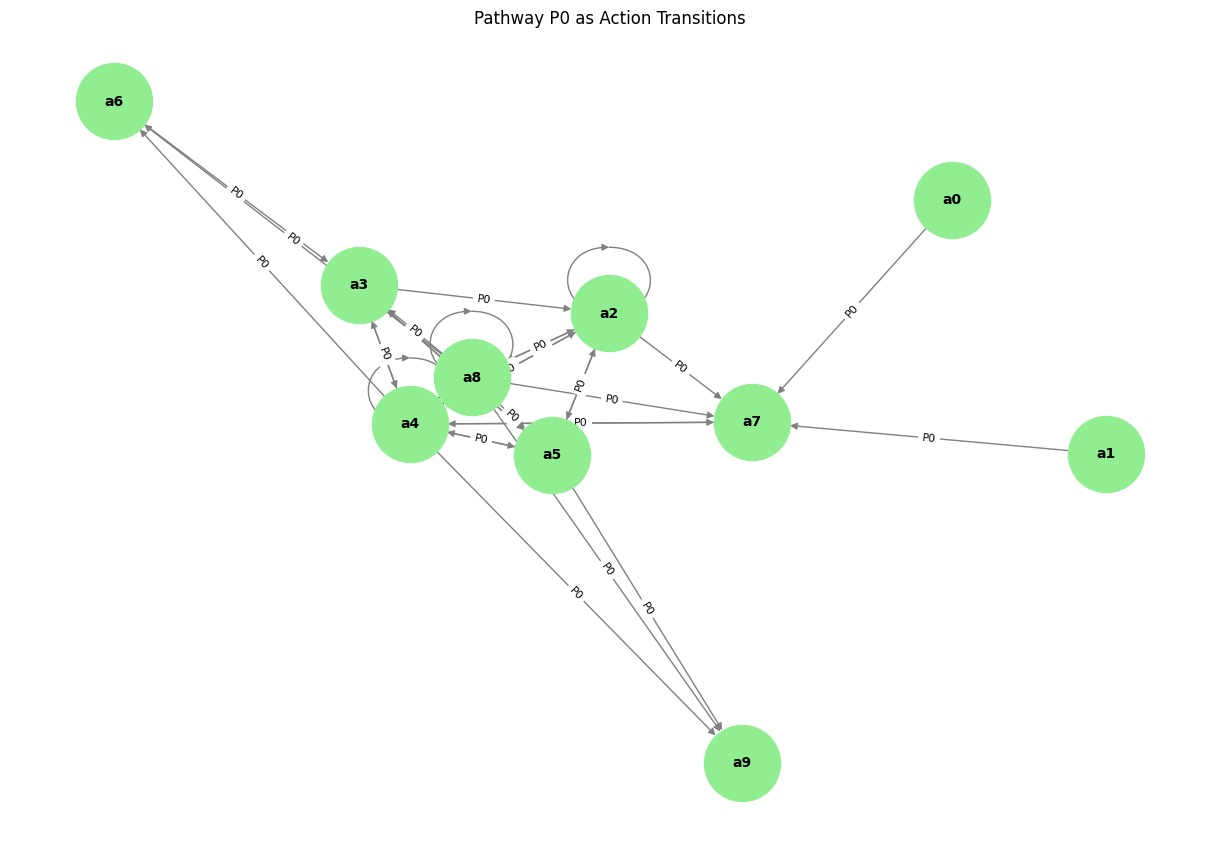

In [11]:
# Visualize a single pathway as a set of action transitions using a directed graph
plt.figure(figsize=(12, 8))
G_transitions_single = nx.DiGraph()

# Specify the pathway to visualize
selected_pathway = 'P0'  # Change this to the desired pathway

# Add nodes and edges for the selected pathway
if selected_pathway in transition_matrix:
    actions_transitions = transition_matrix[selected_pathway]
    for action, next_actions in actions_transitions.items():
        for next_action in next_actions:
            G_transitions_single.add_edge(action, next_action, label=selected_pathway)

# Draw the graph
pos = nx.spring_layout(G_transitions_single, seed=42)  # Layout for better visualization
nx.draw(G_transitions_single, pos, with_labels=True, node_size=3000, node_color="lightgreen", font_size=10, font_weight="bold", edge_color="gray")
edge_labels = nx.get_edge_attributes(G_transitions_single, 'label')
nx.draw_networkx_edge_labels(G_transitions_single, pos, edge_labels=edge_labels, font_size=8)

plt.title(f"Pathway {selected_pathway} as Action Transitions")
plt.show()

# Step 3: Setup Learning

The Q-learning implementation interacts with the simulation by dynamically adjusting the `q_threshold` parameter for patient action selection in pathways, influencing the flow of patients through the healthcare system. Here’s how it works:

1. **State Representation**:
    - In the Q-learning setup, the `state` is represented by the pathway name (`pw.name`).
    - Each pathway acts as a state in the Q-learning algorithm.

2. **Action Selection**:
    - The `choose_q_action(q_state)` function uses an epsilon-greedy policy to select an action. Actions are represented as numerical values (`-3` to `3`) and are passed as `q_threshold` to the pathway's `next_action()` method.

3. **Threshold Adjustment**:
    - For each pathway, the selected action (`q_threshold`) influences the logic in `next_action()`, affecting how patients are routed through actions (favoring lower cost or higher effect actions depending on the sign and magnitude of `q_threshold`).

4. **Simulation Integration**:
    - During each simulation step, the chosen `q_threshold` for each pathway is used in `next_action()` to determine the next action for each patient.

5. **Reward Calculation**:
    - After executing all actions in a simulation step, the total cost (`step_cost`) is calculated.
    - The reward is computed as a negative value of the step cost, with additional penalties for queue time and clinical penalties:
      ```python
      reward = -step_cost - 0.01 * queue_penalty - 0.1 * clinical_penalty
      ```

6. **Q-value Update**:
    - For each `(q_state, q_action)` pair used in the step, the Q-value is updated using the Q-learning formula:
      ```python
      q_table[q_state][q_action] += alpha * (reward + gamma * max(q_table[q_state].values()) - q_table[q_state][q_action])
      ```

### Interaction Summary:
- The Q-learning algorithm dynamically adjusts the `q_threshold` parameter for each pathway during the simulation.
- These adjustments influence patient transitions, action assignments, and overall system behavior.
- The simulation provides feedback (via costs and penalties) to the Q-learning algorithm, enabling it to learn and optimize the system over time.

In [12]:
# Q-learning parameters
q_table = defaultdict(lambda: defaultdict(float))
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate

def choose_q_action(q_state):
    """
    Choose an action based on the epsilon-greedy policy.
    """
    if random.random() < epsilon:
        return random.choice([-3,-2, -1, 0, 1, 2, 3])
    return max([-3, -2, -1, 0, 1, 2, 3], key=lambda a: q_table[q_state][a])

def compute_reward(step_cost, patients):
    # Example: Non-linear penalty for high queue times, clinical penalties and system cost
    queue_penalty = sum((p.queue_time ** 2 for p in patients))  # Quadratic penalty
    clinical_penalty = sum(np.exp(p.outcomes['clinical_penalty'] / 50) for p in patients)  # Exponential penalty
    reward = -step_cost - 0.01 * queue_penalty - 0.1 * clinical_penalty
    return reward


# Step 4: Run the Simulation

In [ ]:
# Step 6: Run Simulation with Queues
"""
This step simulates the flow of patients through the healthcare system. The simulation tracks the clinical variables of each patient, 
determines their next actions based on predefined pathways, and executes those actions while calculating the associated costs.

1. A loop runs for `NUM_STEPS`, representing each time step in the simulation.
2. The `progress_disease()` method is called to simulate the natural decline in their clinical variables over time and occurence of diseases.
3. For each patient and each pathway in the `pathways` list:
    - The `next_action()` method is called to determine the next action for the patient based on their clinical variables and the pathway's thresholds.
    - If a valid next action is identified and exists in the `actions` dictionary, the patient is assigned to the action's queue, and the action is added to the patient's history.
4. For each action in the `actions` dictionary:
    - The `execute()` method is called to process patients in the action's queue, apply the action's effects, and calculate the cost incurred.
    - The cost for the action is added to the `step_cost`.
5. The total cost for the current time step (`step_cost`) is appended to the `system_cost` list.

"""
system_cost = []
q_threshold_rewards = []
activity_log = []
q_state_action_pairs = []
for step in range(NUM_STEPS):
    step_cost = 0
    for patient in patients:
        patient.clinical_decay(patient)  # Simulate natural decay of clinical variables
        for pw in pathways: 
            
            q_state = pw.name  # Use pathway name as the state
            q_action = choose_q_action(q_state) # Q-learning: Adjust AGE_THRESHOLD dynamically    
            q_state_action_pairs.append((q_state, q_action))
            #q_action = 0  # Uncomment to turn q-learning off!
            print(f"Step {step}, Patient {patient.pid}, Pathway {pw.name}, Q-Action: {q_action}")
            
            if patient.diseases[pw.name] == False:  # Only progress if disease is present
                patient.progress_diseases(patient, pw.name) # Simulate disease occurrence
                continue

            next_a = pw.next_action(patient,q_action) # Determine next action based on pathway and q_action
            
            if next_a == output_actions: # Handle output action logic
                Action.handle_output_action(patient, pw, next_a)
                
    for act in actions.values():
        in_progress, cost = act.execute()
        step_cost += cost
        
    system_cost.append(step_cost)
    reward = compute_reward(step_cost, patients)
    q_threshold_rewards.append((q_action, reward))

    # Q-table update for all state-action pairs in this step
    for q_state, q_action in q_state_action_pairs:
        q_table[q_state][q_action] += alpha * (reward + gamma * max(q_table[q_state].values()) - q_table[q_state][q_action])

# Step 5: Visualise the Outputs

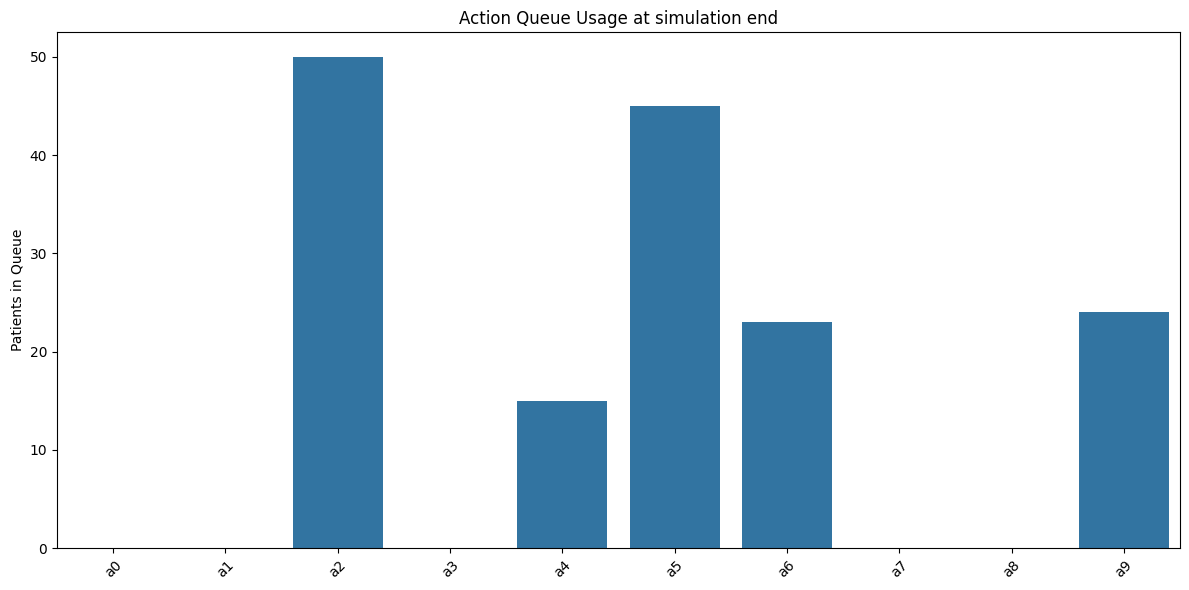

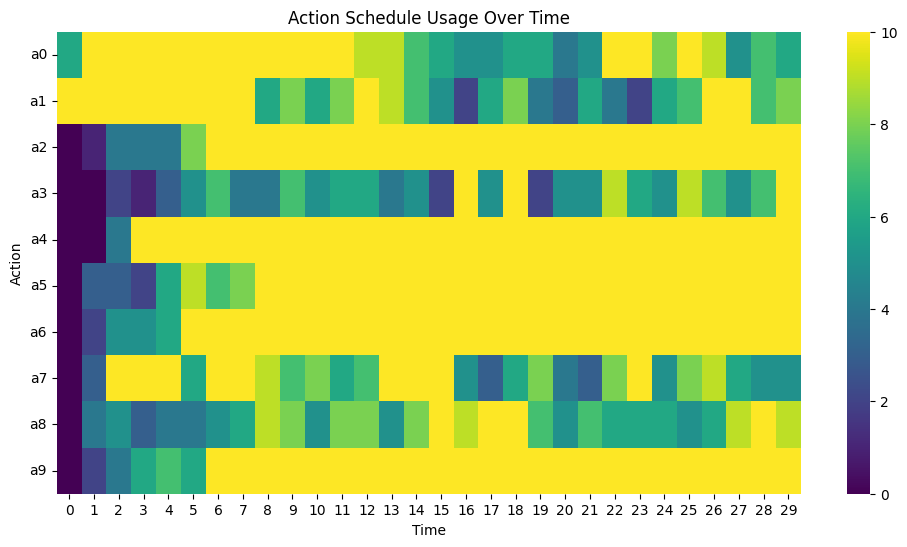

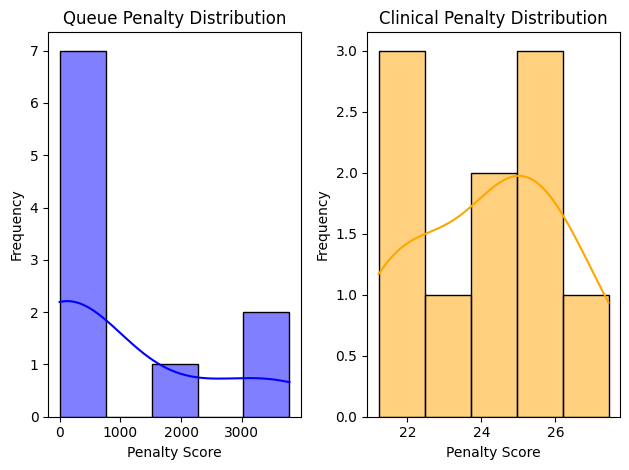

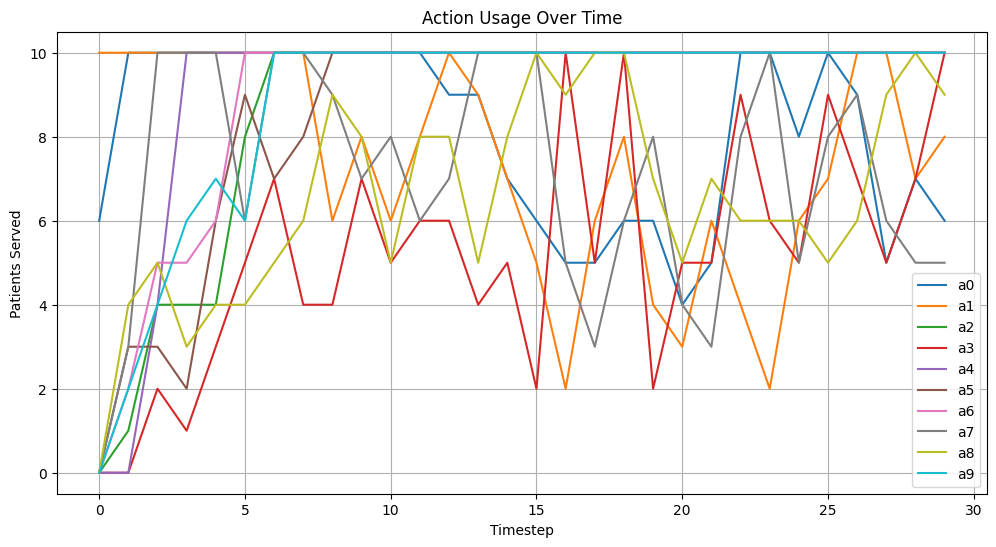

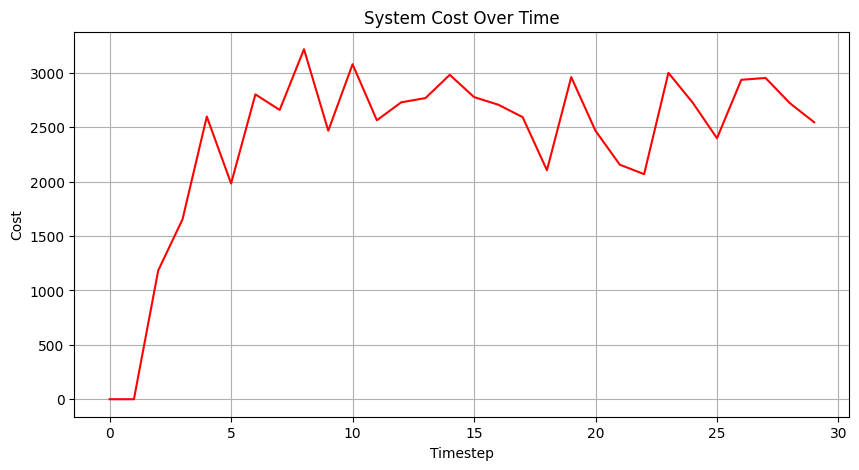

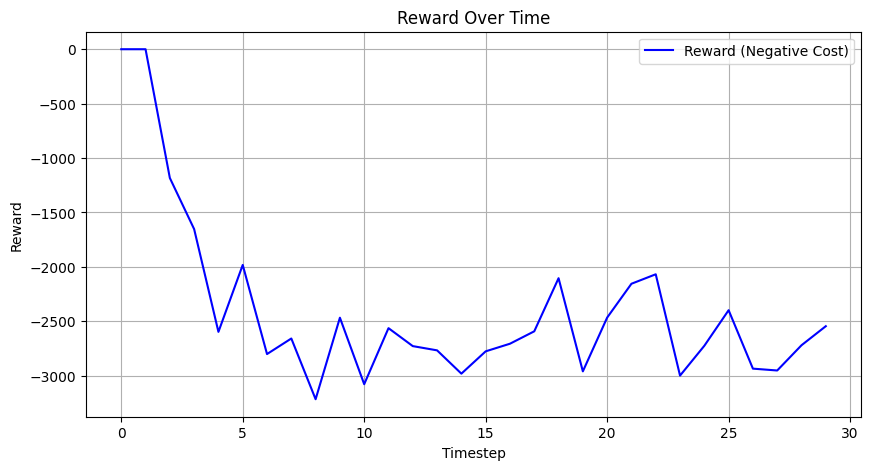

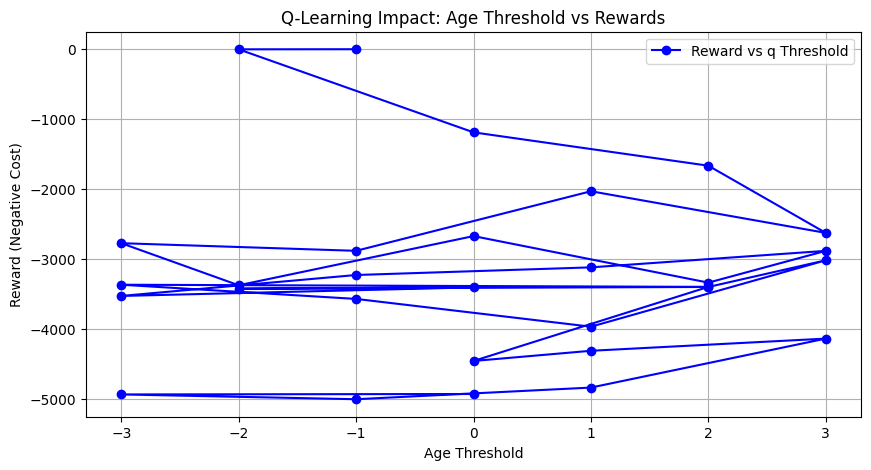

Total system cost: 71775
Average queue penalty: 979.7
Average clinical penalty: 24.205058134319295
Average wait time: 151.3
Average clinical variables: {'bp': 100.99975340831006, 'glucose': 90.34153781213973, 'bmi': 21.611308311205057, 'oxygen': 98.08619338975646, 'mental_health': 80.65291090185046}


In [14]:
# Step 7: Visualizations
"""
This cell provides various visualizations to analyze the simulation results:

1. **Action Queue Usage**:
    - A bar plot showing the number of patients in the queue for each action at the end of the simulation.

2. **Action Schedule Usage Over Time**:
    - A heatmap displaying the number of patients served by each action over time.

3. **Wait Time by Patient Priority**:
    - A boxplot illustrating the distribution of wait times for patients based on their priority levels.

4. **Penalty Distributions**:
    - Histograms showing the distribution of queue penalties and clinical penalties across all patients.

5. **Action Usage Over Time**:
    - A line plot showing the number of patients served by each action at each timestep.

6. **System Cost Over Time**:
    - A line plot showing the total system cost at each timestep.

7. **Reward Over Time**:
    - A line plot showing the reward (negative cost) over time, reflecting the system's performance.

8. **Q-values for State-Action Pairs**:
    - A line plot showing the Q-values for each state-action pair, providing insights into the learning process.

9. **Age Threshold vs Rewards**:
    - A line plot showing the relationship between dynamically adjusted age thresholds and the corresponding rewards (negative costs).
"""

plt.figure(figsize=(12, 6))
plt.title("Action Queue Usage at simulation end")
sns.barplot(x=list(actions.keys()), y=[len(act.queue) for act in actions.values()])
plt.ylabel("Patients in Queue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

heatmap_data = np.array([act.schedule for act in actions.values()])

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="viridis", annot=False, cbar=True)
plt.title("Action Schedule Usage Over Time")
plt.xlabel("Time")
plt.ylabel("Action")
plt.yticks(ticks=np.arange(len(actions)) + 0.5, labels=list(actions.keys()), rotation=0)
plt.show()

# Subplot 1: Queue Penalty
plt.subplot(1, 2, 1)
sns.histplot([p.outcomes['queue_penalty'] for p in patients], kde=True, color='blue')
plt.title("Queue Penalty Distribution")
plt.xlabel("Penalty Score")
plt.ylabel("Frequency")

# Subplot 2: Clinical Penalty
plt.subplot(1, 2, 2)
sns.histplot([p.outcomes['clinical_penalty'] for p in patients], kde=True, color='orange')
plt.title("Clinical Penalty Distribution")
plt.xlabel("Penalty Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Queue usage
plt.figure(figsize=(12,6))
for name, act in actions.items():
    plt.plot(act.schedule, label=name)
plt.title("Action Usage Over Time")
plt.xlabel("Timestep")
plt.ylabel("Patients Served")
plt.legend()
plt.grid(True)
plt.show()

# System cost over time
plt.figure(figsize=(10,5))
plt.plot(system_cost, color='red')
plt.title("System Cost Over Time")
plt.xlabel("Timestep")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

# Visualize the reward over time
plt.figure(figsize=(10, 5))
plt.plot([-cost for cost in system_cost], label="Reward (Negative Cost)", color="blue")
plt.title("Reward Over Time")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()

# Extract age_thresholds and rewards from age_threshold_rewards
q_thresholds, rewards = zip(*q_threshold_rewards)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(q_thresholds, rewards, marker='o', linestyle='-', color='blue', label='Reward vs q Threshold')
plt.title("Q-Learning Impact: Age Threshold vs Rewards")
plt.xlabel("Age Threshold")
plt.ylabel("Reward (Negative Cost)")
plt.grid(True)
plt.legend()
plt.show()

print("Total system cost:", sum(system_cost))
print("Average queue penalty:", np.mean([p.outcomes['queue_penalty'] for p in patients]))
print("Average clinical penalty:", np.mean([p.outcomes['clinical_penalty'] for p in patients]))
print("Average wait time:", np.mean([p.queue_time for p in patients]))
print("Average clinical variables:", {k: np.mean([p.clinical[k] for p in patients]) for k in IDEAL_CLINICAL_VALUES.keys()})

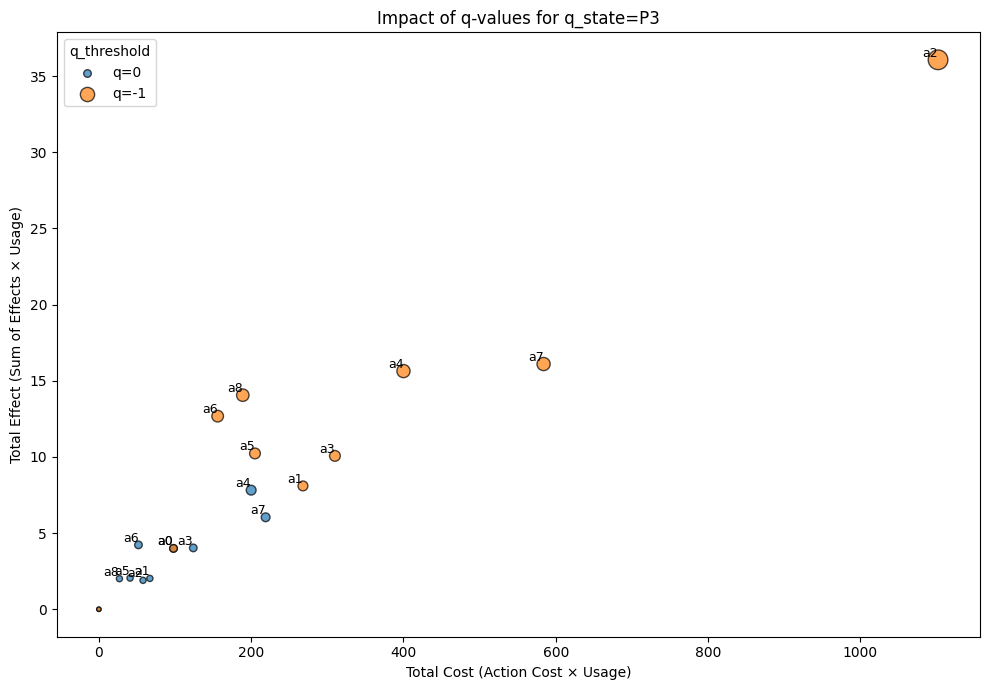

Best Q-learning action per pathway (state):
  Pathway: P0 | Best q_threshold: 0 | Q-value: -45557.05
  Pathway: P1 | Best q_threshold: 0 | Q-value: -45519.72
  Pathway: P2 | Best q_threshold: 0 | Q-value: -45676.73
  Pathway: P3 | Best q_threshold: -1 | Q-value: -45790.30
  Pathway: P4 | Best q_threshold: -2 | Q-value: -45706.03
  Pathway: P5 | Best q_threshold: 3 | Q-value: -45719.81
  Pathway: P6 | Best q_threshold: -2 | Q-value: -45736.71
  Pathway: P7 | Best q_threshold: 1 | Q-value: -45656.87
  Pathway: P8 | Best q_threshold: -1 | Q-value: -45557.89
  Pathway: P9 | Best q_threshold: -2 | Q-value: -45775.22


In [15]:
# Summarize what Q-learning has learnt: best action per pathway (state)
best_actions = {}
for state, actions_dict in q_table.items():
    if actions_dict:
        best_action = max(actions_dict, key=lambda a: actions_dict[a])
        best_q = actions_dict[best_action]
        best_actions[state] = (best_action, best_q)
        
# Aggregate usage, cost, and effect for each action and q-value for a single q_state
q_state = 'P3'
possible_q_values = [0, best_actions.get(q_state, (None, 0))[0]]
action_names = list(actions.keys())
df = pd.DataFrame(activity_log)
q_state_action_df = pd.DataFrame(q_state_action_pairs, columns=['q_state', 'q_value'])
q_state_action_df['step'] = q_state_action_df.index // NUM_PATHWAYS

# Prepare a DataFrame for aggregation
agg_data = []
for q_val in possible_q_values:
    # Steps where this q_state had this q_value
    steps = q_state_action_df[(q_state_action_df['q_state'] == q_state) & (q_state_action_df['q_value'] == q_val)]['step'].unique()
    # Filter activity for this q_state and these steps
    state_df = df[(df['pathway_code'] == q_state) & (df['simulation_time'].isin(steps))]
    for action in action_names:
        usage = state_df['action_name'].value_counts().get(action, 0)
        total_cost = actions[action].cost * usage
        total_effect = sum(abs(v) for v in actions[action].effect.values()) * usage
        agg_data.append({
            'q_value': q_val,
            'action': action,
            'usage': usage,
            'total_cost': total_cost,
            'total_effect': total_effect
        })

agg_df = pd.DataFrame(agg_data)

# Plot
plt.figure(figsize=(10, 7))
colors = dict(zip(possible_q_values, sns.color_palette("tab10", len(possible_q_values))))
for q_val in possible_q_values:
    subset = agg_df[agg_df['q_value'] == q_val]
    plt.scatter(
        subset['total_cost'],
        subset['total_effect'],
        s=subset['usage']*10 + 10,  # Bubble size
        color=colors[q_val],
        alpha=0.7,
        label=f'q={q_val}',
        edgecolors='black'
    )
    # Annotate action names
    for _, row in subset.iterrows():
        if row['usage'] > 0:
            plt.text(row['total_cost'], row['total_effect'], row['action'], fontsize=9, ha='right', va='bottom')

plt.xlabel("Total Cost (Action Cost × Usage)")
plt.ylabel("Total Effect (Sum of Effects × Usage)")
plt.title(f"Impact of q-values for q_state={q_state}")
plt.legend(title="q_threshold")
plt.tight_layout()
plt.show()

print("Best Q-learning action per pathway (state):")
for state, (action, q_value) in best_actions.items():
    print(f"  Pathway: {state} | Best q_threshold: {action} | Q-value: {q_value:.2f}")

### Seeds set to zero and q-learning turned off

Total system cost: 79298

Average queue penalty: 1695.0

Average clinical penalty: 24.072130319255244

Average wait time: 152.0

Average clinical variables: {'bp': 101.63407345440639, 'glucose': 89.71730550340759, 'bmi': 22.11140459285633, 'oxygen': 97.09401427371196, 'mental_health': 80.40158540727238}

Best Q-learning action per pathway (state):

|  |  |  |
|--|--|--|
|  Pathway: P0 | Best q_threshold: 0 | Q-value: -51431.22 |
|  Pathway: P1 | Best q_threshold: 0 | Q-value: -51529.29 |
|  Pathway: P2 | Best q_threshold: 0 | Q-value: -51482.96 |
|  Pathway: P3 | Best q_threshold: 0 | Q-value: -51261.64 |
|  Pathway: P5 | Best q_threshold: 0 | Q-value: -51503.65 |
|  Pathway: P6 | Best q_threshold: 0 | Q-value: -51422.84 |
|  Pathway: P7 | Best q_threshold: 0 | Q-value: -51645.68 |
|  Pathway: P8 | Best q_threshold: 0 | Q-value: -51364.57 |
|  Pathway: P9 | Best q_threshold: 0 | Q-value: -51519.21 |
|  Pathway: P4 | Best q_threshold: 0 | Q-value: -51481.00 |

### Seeds set to zero and q-learning turned on

Total system cost: 73627

Average queue penalty: 2460.1

Average clinical penalty: 27.920978757587385

Average wait time: 142.3

Average clinical variables: {'bp': 100.38514663991313, 'glucose': 89.80040037148892, 'bmi': 22.17657530032658, 'oxygen': 95.54348813254944, 'mental_health': 78.75233106841272}

Best Q-learning action per pathway (state):

|  |  |  |
|--|--|--|
|  Pathway: P0 | Best q_threshold: 2 | Q-value: -46999.13 |
|  Pathway: P1 | Best q_threshold: 0 | Q-value: -47122.40 |
|  Pathway: P2 | Best q_threshold: -2 | Q-value: -47123.83 | 
|  Pathway: P3 | Best q_threshold: -1 | Q-value: -47092.95 |
|  Pathway: P5 | Best q_threshold: 1 | Q-value: -47244.99 |
|  Pathway: P6 | Best q_threshold: -3 | Q-value: -47188.13 |
|  Pathway: P7 | Best q_threshold: -2 | Q-value: -46950.68 |
|  Pathway: P8 | Best q_threshold: 0 | Q-value: -47093.58 |
|  Pathway: P9 | Best q_threshold: 2 | Q-value: -47152.03 |
|  Pathway: P4 | Best q_threshold: 2 | Q-value: -47273.64 |
  

,pathway_code,pathway_flag,patient_id,simulation_time,previous_action,action_name,next_action
27,P6,True,3,2,None,a1,a7
55,P6,True,3,3,a1,a7,a4
95,P6,True,3,4,a7,a4,a9
621,P6,True,3,14,a9,a1,a7
676,P6,True,3,15,a1,a7,a4
735,P6,True,3,16,a7,a4,a9
1046,P6,True,3,22,a9,a0,a8
1095,P6,True,3,23,a0,a8,a6
1146,P6,True,3,24,a8,a6,a9


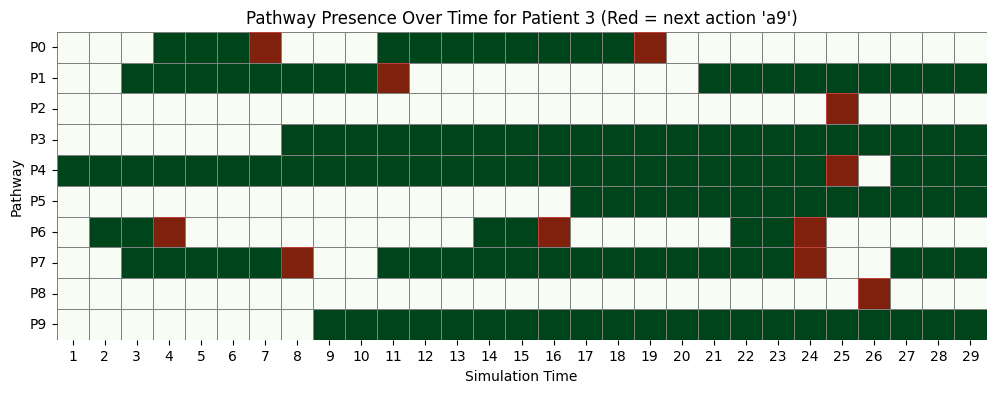

In [16]:
# Display activity_log as a DataFrame (tabular form)
activity_df = pd.DataFrame(activity_log)
# filter to one example patient for clarity
example_patient_df = activity_df[activity_df['patient_id'] == 3]
example_patient_pathway_df = example_patient_df[example_patient_df['pathway_code'] == 'P6']
#example_patient_df = activity_df

display(example_patient_pathway_df.head(20))  

timesteps = sorted(example_patient_df['simulation_time'].unique())
all_pathways = sorted(example_patient_df['pathway_code'].unique())

# Build a DataFrame: index=timesteps, columns=pathways, value=1 if patient is on that pathway at that time
presence_matrix = pd.DataFrame(0, index=timesteps, columns=all_pathways)
for t in timesteps:
    active_pathways = example_patient_df[example_patient_df['simulation_time'] == t]['pathway_code'].unique()
    for pw in active_pathways:
        presence_matrix.loc[t, pw] = 1

plt.figure(figsize=(12, 4))
ax = sns.heatmap(presence_matrix.T, cmap="Greens", cbar=False, linewidths=0.5, linecolor='gray')

# Overlay red squares where the next action is 'a9' for patient 3
for idx, row in example_patient_df.iterrows():
    if row['next_action'] == 'a9':
        # simulation_time is x, pathway_code is y
        x = row['simulation_time'] - 1  # adjust for zero-based index in heatmap
        y = all_pathways.index(row['pathway_code'])
        ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color='red', alpha=0.5, lw=0))

plt.title(f"Pathway Presence Over Time for Patient 3 (Red = next action 'a9')")
plt.xlabel("Simulation Time")
plt.ylabel("Pathway")
plt.yticks(ticks=np.arange(len(all_pathways)) + 0.5, labels=all_pathways, rotation=0)
plt.show()

# Prepare data for Sankey diagram
filtered_df = example_patient_pathway_df.dropna(subset=['action_name','next_action'])
sources = filtered_df['action_name']
targets = filtered_df['next_action']
labels = list(pd.unique(pd.concat([sources, targets])))

# Cut the 'a9' output action from the Sankey diagram
mask = sources != 'a9'
filtered_sources = sources[mask]
filtered_targets = targets[mask]

values = [1] * len(filtered_df)  # Each transition counts as 1

left_nodes = ['a0', 'a1']
right_nodes = ['a9']
middle_nodes = [l for l in labels if l not in left_nodes + right_nodes]
ordered_labels = left_nodes + middle_nodes + right_nodes

# Remap indices for sources and targets
label_indices_ordered = {label: idx for idx, label in enumerate(ordered_labels)}
source_indices_ordered = filtered_sources.map(label_indices_ordered)
target_indices_ordered = filtered_targets.map(label_indices_ordered)

# Set x positions: 0 for left, 1 for right, 0.5 for middle
x_positions = [i / (len(ordered_labels) - 1) for i in range(len(ordered_labels))]
for label in ordered_labels:
    if label in left_nodes:
        x_positions.append(0.0)
    elif label in right_nodes:
        x_positions.append(1.0)
    else:
        x_positions.append(0.5)

# Optional: set y positions to spread nodes vertically
y_positions = [i / (len(ordered_labels) - 1) for i in range(len(ordered_labels))]


fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=ordered_labels,
        x=x_positions,
        y=y_positions,
    ),
    link=dict(
        source=source_indices_ordered,
        target=target_indices_ordered,
        value=values,
    ))])

fig.update_layout(title_text="Patient Action Flow (Sankey Diagram)", font_size=10)
fig.show()

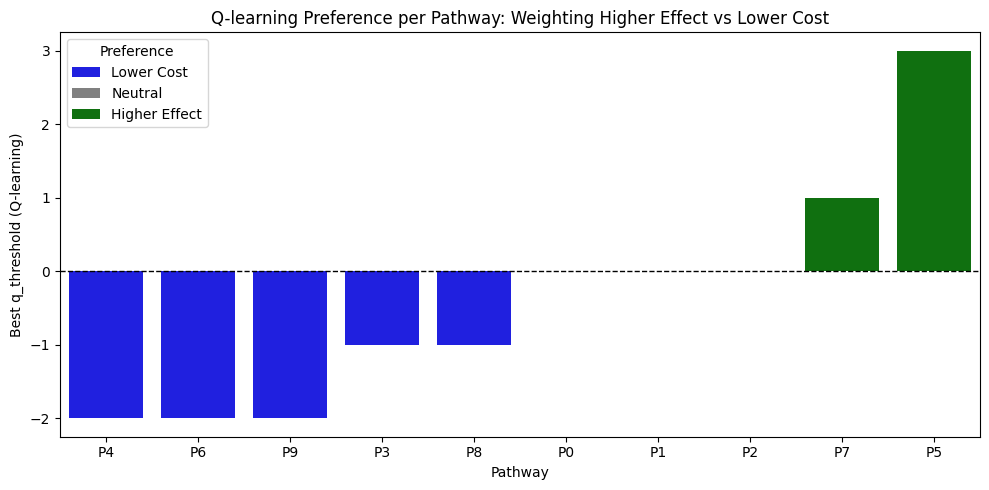

In [17]:
# Visualize for each pathway the Q-learning preference: higher effect (positive q_threshold) vs lower cost (negative q_threshold)
all_pathways = sorted(example_patient_df['pathway_code'].unique())
# Prepare data: for each pathway, get the best q_threshold and its sign
q_pref_df = pd.DataFrame([
    {"Pathway": state, "Best_q_threshold": best_actions[state][0], "Q_value": best_actions[state][1]}
    for state in all_pathways if state in best_actions
])
q_pref_df["Preference"] = q_pref_df["Best_q_threshold"].apply(lambda x: "Higher Effect" if x > 0 else ("Lower Cost" if x < 0 else "Neutral"))

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=q_pref_df.sort_values("Best_q_threshold"),
    x="Pathway",
    y="Best_q_threshold",
    hue="Preference",
    dodge=False,
    palette={"Higher Effect": "green", "Lower Cost": "blue", "Neutral": "gray"}
)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Q-learning Preference per Pathway: Weighting Higher Effect vs Lower Cost")
plt.ylabel("Best q_threshold (Q-learning)")
plt.xlabel("Pathway")
plt.legend(title="Preference")
plt.tight_layout()
plt.show()